# April 25-30, 2022: create emoprox2 stimuli/regressors
<!-- Idea1, don't-care time segments: create dataset -->

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy

# explanation tools
import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/apr22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.base_model as base_model
import helpers.model_definitions as model_definitions
import data.emoprox2.scripts.stimulus_utils as stimulus_utils

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-05-03 14:10:48.481320: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-03 14:10:50.532712: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-03 14:10:50.539707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-03 14:10:50.539873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-03 14:10:50.539890: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

In [2]:
def get_subj_timing_dfs(base_timing_dfs, subj_timings, run_list):
    '''
    base_timing_dfs : per run, per block
    block_timings: per run
    shock_timings: per run, split per block
    '''
    subj_timing_dfs = copy.deepcopy(base_timing_dfs)
    for run, block in list(product(run_list, range(2))):
        block_base_timing_df = base_timing_dfs[run][block].copy()
        block_timings, shock_timings, run_duration = subj_timings[run]

        # separate appr and retr stimuli
        block_base_timing_df['appr'] = (block_base_timing_df['direction'] == 1.0).values.astype(float)
        block_base_timing_df['retr'] = (block_base_timing_df['direction'] == -1.0).values.astype(float)

        # time in seconds
        block_start, block_stop = block_timings[block]
        block_base_timing_df['time'] = np.linspace(block_start, block_stop, num=len(block_base_timing_df))

        # times of electrical stimulation
        block_base_timing_df['shock_time'] = np.zeros_like(block_base_timing_df['time'])
        for idx_shock, shock in enumerate(shock_timings[block]):
            idx_shock_start = abs(block_base_timing_df['time'] - shock[0]).idxmin()
            idx_shock_stop = abs(block_base_timing_df['time'] - shock[1]).idxmin() 
            block_base_timing_df['shock_time'][idx_shock_start: idx_shock_stop] = 1.0
        
        # store properly
        subj_timing_dfs[run][block] = block_base_timing_df  
    return subj_timing_dfs

In [3]:
# convolve with hrf
BASECOLS = ['proximity', 'direction', 'appr', 'retr', 'shock_time']
MAX_TIME = 500 # in seconds

def h(t, p=8.6, q=0.547, tau=5.0):
    # return 1.0 if ((t >= 0.0) and (t <= tau)) else 0.0 
    return np.power((t/(p*q)), p) * np.exp(p-t/q)

def take_samples(signal, times):
    signal_discrete = np.zeros_like(times)
    for idx_time, time in enumerate(times):
        signal_discrete[idx_time] = signal(time)
    return signal_discrete

def convolve_hrf(x, hrf, delta_t):
    y = np.convolve(x, hrf, 'full') * delta_t 
    # this is approximation of the integration done in convolution of two continuous signals. 
    # since those two signals were sampled, we need to multiply the product 
    # of the two signals with `delta_t` to approximate the integration.

    # but here for visualizing/ using regressors similar to how afni does, 
    # we are normalizing the convolved response
    y /= np.max(np.abs(y))
    return y #y[:x.shape[0]]

def get_convolved_regressors(subj_timing_dfs, run_list):
    for run, block in list(product(run_list, range(2))): 
        df = subj_timing_dfs[run][block]

        # sample the hrf kernel 
        # as block0 has time starting from 0 seconds, use times from there.
        t = subj_timing_dfs[run][0]['time'][0:500]
        delta_t = t[1] - t[0]
        hrf = take_samples(h, t)

        # create a new longer df to include convolved signals 
        df_conv = pd.DataFrame(
            np.nan, 
            index=np.arange(len(df)+hrf.shape[0]-1), 
            columns=df.columns)
        df_conv.iloc[:len(df)] = df.iloc[:]

        # add times in seconds
        times = df['time']
        dt = times[1] - times[0]
        t_stop = MAX_TIME #times.iloc[0] + (len(df_conv)) * dt
        df_conv['time'] = np.arange(start=times.iloc[0], stop=t_stop, step=dt)[:len(df_conv)]

        # convolve base signals/ columns of df
        for COL in BASECOLS:
            x = df[COL]
            y = convolve_hrf(x, hrf, delta_t)
            df_conv[f"{COL}_conv"] = y
        
        subj_timing_dfs[run][block] = df_conv
    
    return subj_timing_dfs

In [4]:
# times closest to each TR: 
# indexes where data will be sampled at every TR
# idx == -1 implies that TR does not lie inside either block.
tr = 1.25
def return_closest_time(df, fps=1/30):
    TR_list = np.arange(0,360*tr,tr)
    diff_thresh = fps
    
    idx_list = -1 * np.ones(len(TR_list), dtype=np.int)

    for i, TR in enumerate(TR_list):
        diff = np.abs(df.time.values - TR)
        if np.min(diff) <= diff_thresh:
            idx_list[i] = np.argmin(diff)
    
    return idx_list

In [5]:
def get_subj_tr_dfs(subj, run_list):
    subj_timings = [None for _ in np.arange(6)]
    for idx_run, run in enumerate(run_list):
        subj_timings[run] = stimulus_utils.subj_timing(subj, run)
    # block_timings, shock_timings, run_duration = \
    # stimulus_utils.subj_timing(subj, run)

    # align the base stimuli to the scanning-times of the subject
    subj_timing_dfs = get_subj_timing_dfs(base_timing_dfs, subj_timings, run_list)

    # convolve base stimuli with hrf kernel
    subj_timing_dfs = get_convolved_regressors(subj_timing_dfs, run_list)

    # resample the block-wise dataframes to TR resolution
    idx_lists = [None for _ in np.arange(6)]
    for run in run_list:
        idx_lists[run] = return_closest_time(
            pd.concat([subj_timing_dfs[run][0], subj_timing_dfs[run][1]]))

    subj_tr_dfs = [None for _ in np.arange(6)] 
    # single df per run, and time will be indexed by TR

    for run in run_list:
        idx_list = idx_lists[run]
        df = pd.concat([subj_timing_dfs[run][0], subj_timing_dfs[run][1]])
        df_tr = pd.DataFrame(
            np.nan, 
            index=np.arange(len(idx_list)), 
            columns=df.columns)

        blocks = dataset_utils.contiguous_regions(idx_list!=-1)
        for idx_block in [0, 1]:
            block = blocks[idx_block]
            df_tr.iloc[block[0]:block[1]] = df.iloc[idx_list[block[0]:block[1]]]

        subj_tr_dfs[run] = df_tr
    
    return subj_tr_dfs

In [6]:
base_timing_dfs = [[stimulus_utils.get_base_stimulus(run, block) for block in range(2)] for run in range(6)]

In [7]:
raw_path = '/home/joyneelm/approach-retreat/data/raw'
yoked = pd.read_excel(f"{raw_path}/CON_yoked_table.xlsx", engine='openpyxl')
yoked = yoked.query('use == 1')

In [8]:
yoked

control uncontrol  run0  run1  run2  run3  run4  run5  use
0   CON001    CON031     1     1     1     1     1     0    1
1   CON002    CON021     1     1     1     1     1     1    1
2   CON003    CON022     1     1     1     1     1     1    1
3   CON004    CON030     1     1     1     1     1     1    1
4   CON005    CON023     1     1     1     1     1     1    1
..     ...       ...   ...   ...   ...   ...   ...   ...  ...
58  CON111    CON114     1     1     1     1     1     1    1
59  CON112    CON113     1     1     1     1     1     1    1
60  CON115    CON123     1     1     1     1     1     1    1
61  CON117    CON120     1     1     1     1     1     1    1
62  CON122    CON125     1     1     1     1     1     1    1

[61 rows x 9 columns]

In [9]:
tr_dfs = {}
for _, row in yoked.iterrows():
    for kind in ['control', 'uncontrol']:
        subj = row[kind].replace('CON', '')
        run_list = np.arange(6)[row.loc['run0':'run5'].astype(bool)]

        print(f"{subj} : {run_list}")

        tr_dfs[subj] = get_subj_tr_dfs(subj, run_list)

001 : [0 1 2 3 4]
031 : [0 1 2 3 4]
002 : [0 1 2 3 4 5]
021 : [0 1 2 3 4 5]
003 : [0 1 2 3 4 5]
022 : [0 1 2 3 4 5]
004 : [0 1 2 3 4 5]
030 : [0 1 2 3 4 5]
005 : [0 1 2 3 4 5]
023 : [0 1 2 3 4 5]
006 : [0 1 2 3 4 5]
025 : [0 1 2 3 4 5]
007 : [0 1 2 3 4 5]
016 : [0 1 2 3 4 5]
008 : [0 1 2 3 4 5]
053 : [0 1 2 3 4 5]
009 : [0 1 2 3 4 5]
052 : [0 1 2 3 4 5]
010 : [0 1 2 3 4 5]
089 : [0 1 2 3 4 5]
011 : [0 1 2 3 4 5]
020 : [0 1 2 3 4 5]
012 : [0 1 2 3 4 5]
033 : [0 1 2 3 4 5]
013 : [0 1 2 3 4 5]
019 : [0 1 2 3 4 5]
014 : [0 1 2 3 4 5]
084 : [0 1 2 3 4 5]
015 : [0 1 2 3 4 5]
027 : [0 1 2 3 4 5]
017 : [0 1 2 3 4 5]
049 : [0 1 2 3 4 5]
018 : [0 1 2 3 4 5]
028 : [0 1 2 3 4 5]
024 : [0 1 2 3 4 5]
026 : [0 1 2 3 4 5]
029 : [0 1 2 3 4 5]
054 : [0 1 2 3 4 5]
032 : [0 1 2 3 4 5]
034 : [0 1 2 3 4 5]
035 : [0 1 2 3 4 5]
036 : [0 1 2 3 4 5]
037 : [0 1 2 3 4 5]
058 : [0 1 2 3 4 5]
038 : [0 1 2 3 4 5]
056 : [0 1 2 3 4 5]
039 : [0 1 2 3 4 5]
075 : [0 1 2 3 4 5]
040 : [0 1 2 3 4 5]
072 : [0 1 2 3 4 5]
041 

In [10]:
with open(f"{proj_dir}/data/emoprox2/subj_wise_stimuli.pkl", 'wb') as f:
    pickle.dump(tr_dfs, f)

In [11]:
with open(f"{proj_dir}/data/emoprox2/subj_wise_stimuli.pkl", 'rb') as f:
    tr_dfs = pickle.load(f)

#### plots of all stimuli/regressors

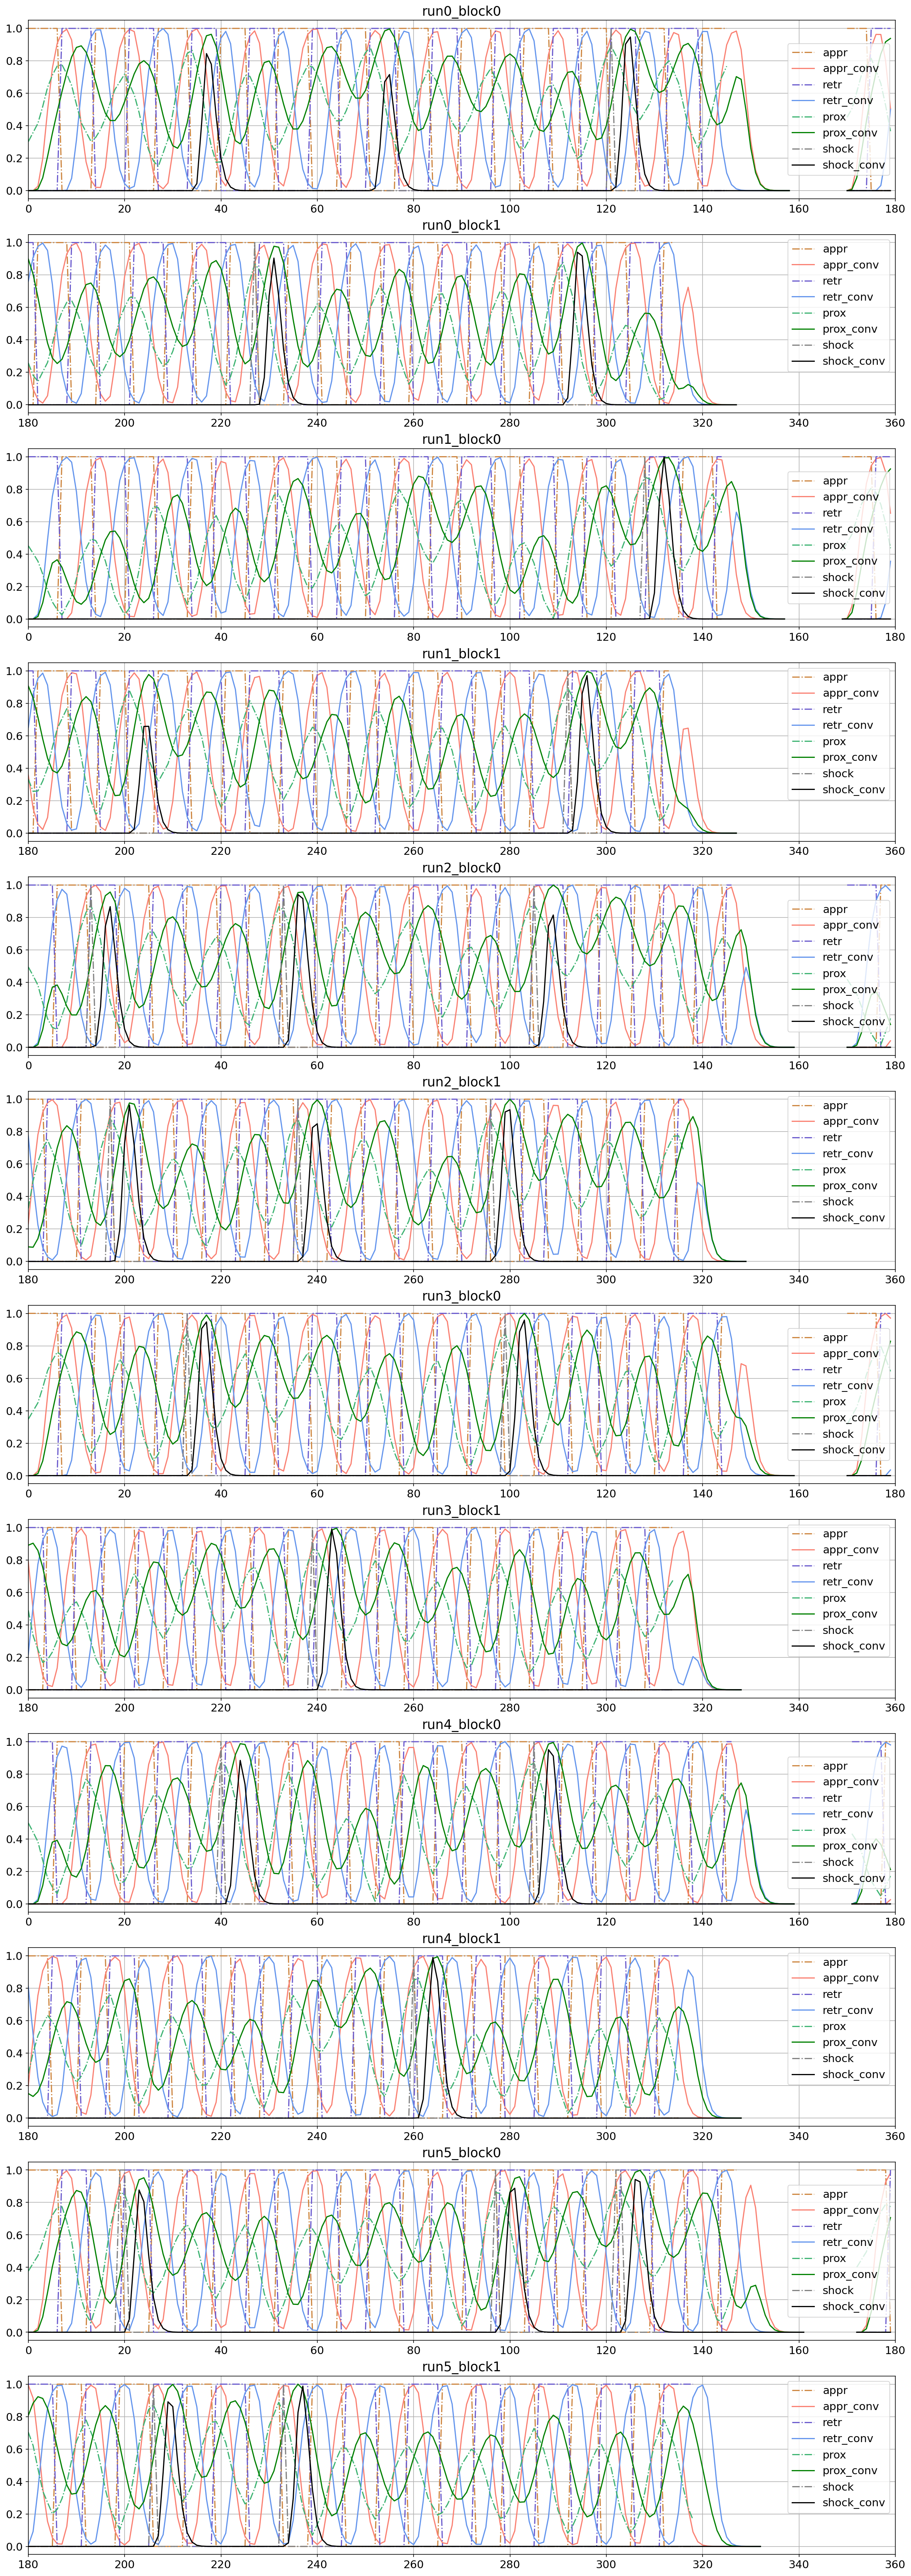

In [12]:
nrows, ncols = 12, 1
subj = '002'
l = 180 # half length of a run
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5*nrows), dpi=150)
for run, block in list(product(run_list, range(2))):
    idx = 2*run + block
    ax = axs[idx]
    ax.plot(tr_dfs[subj][run]['appr'][block*l : (block+1)*l], 
            color='peru', linestyle='-.', label='appr')
    ax.plot(
        tr_dfs[subj][run]['appr_conv'][block*l : (block+1)*l], 
        color='salmon', linestyle='-', label='appr_conv')
    ax.plot(
        tr_dfs[subj][run]['retr'][block*l : (block+1)*l], 
        color='slateblue', linestyle='-.', label='retr')
    ax.plot(
        tr_dfs[subj][run]['retr_conv'][block*l : (block+1)*l], 
        color='cornflowerblue', linestyle='-', label='retr_conv')
    ax.plot(
        tr_dfs[subj][run]['proximity'][block*l : (block+1)*l],
        color='mediumseagreen', linestyle='-.', label='prox')
    ax.plot(
        tr_dfs[subj][run]['proximity_conv'][block*l : (block+1)*l],
        color='green', linestyle='-', label='prox_conv')
    ax.plot(
        tr_dfs[subj][run]['shock_time'][block*l : (block+1)*l],
        color='grey', linestyle='-.', label='shock')
    ax.plot(
        tr_dfs[subj][run]['shock_time_conv'][block*l : (block+1)*l],
        color='black', linestyle='-', label='shock_conv')

    ax.set_title(f"run{run}_block{block}")
    ax.set_xlim(block*l, (block+1)*l)
    ax.legend()
    ax.grid(True)